
<h1>
    <div  align="center"> <h3><font color='Red', size="5">Assignment 2</font>


In [1]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [2]:
#Importing the required libraries
import torch
import pandas as pd
import numpy as np

#Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

from sklearn.metrics import confusion_matrix


import torch.optim as optim
import torch.nn as nn

In [3]:
#reading the data set
df=pd.read_csv("dataset.csv")

In [4]:
df.dtypes

f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
target     int64
dtype: object

In [5]:
#removing rows with alphabatical values
df=df.drop(df.tail(6).index)

In [6]:
# converting the ibject dataype to float
df=df.astype({'f1':'float64','f2':'float64','f4':'float64','f5':'float64','f6':'float64','f7':'float64'})

In [7]:
# main statistics about the entries of the data set
df.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,3.834211,120.969737,69.119737,20.507895,80.234211,31.998684,0.473250,0.350000
std,3.364762,32.023301,19.446088,15.958029,115.581444,7.899724,0.332277,0.477284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.300000,0.243750,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.375500,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


### Visualizations

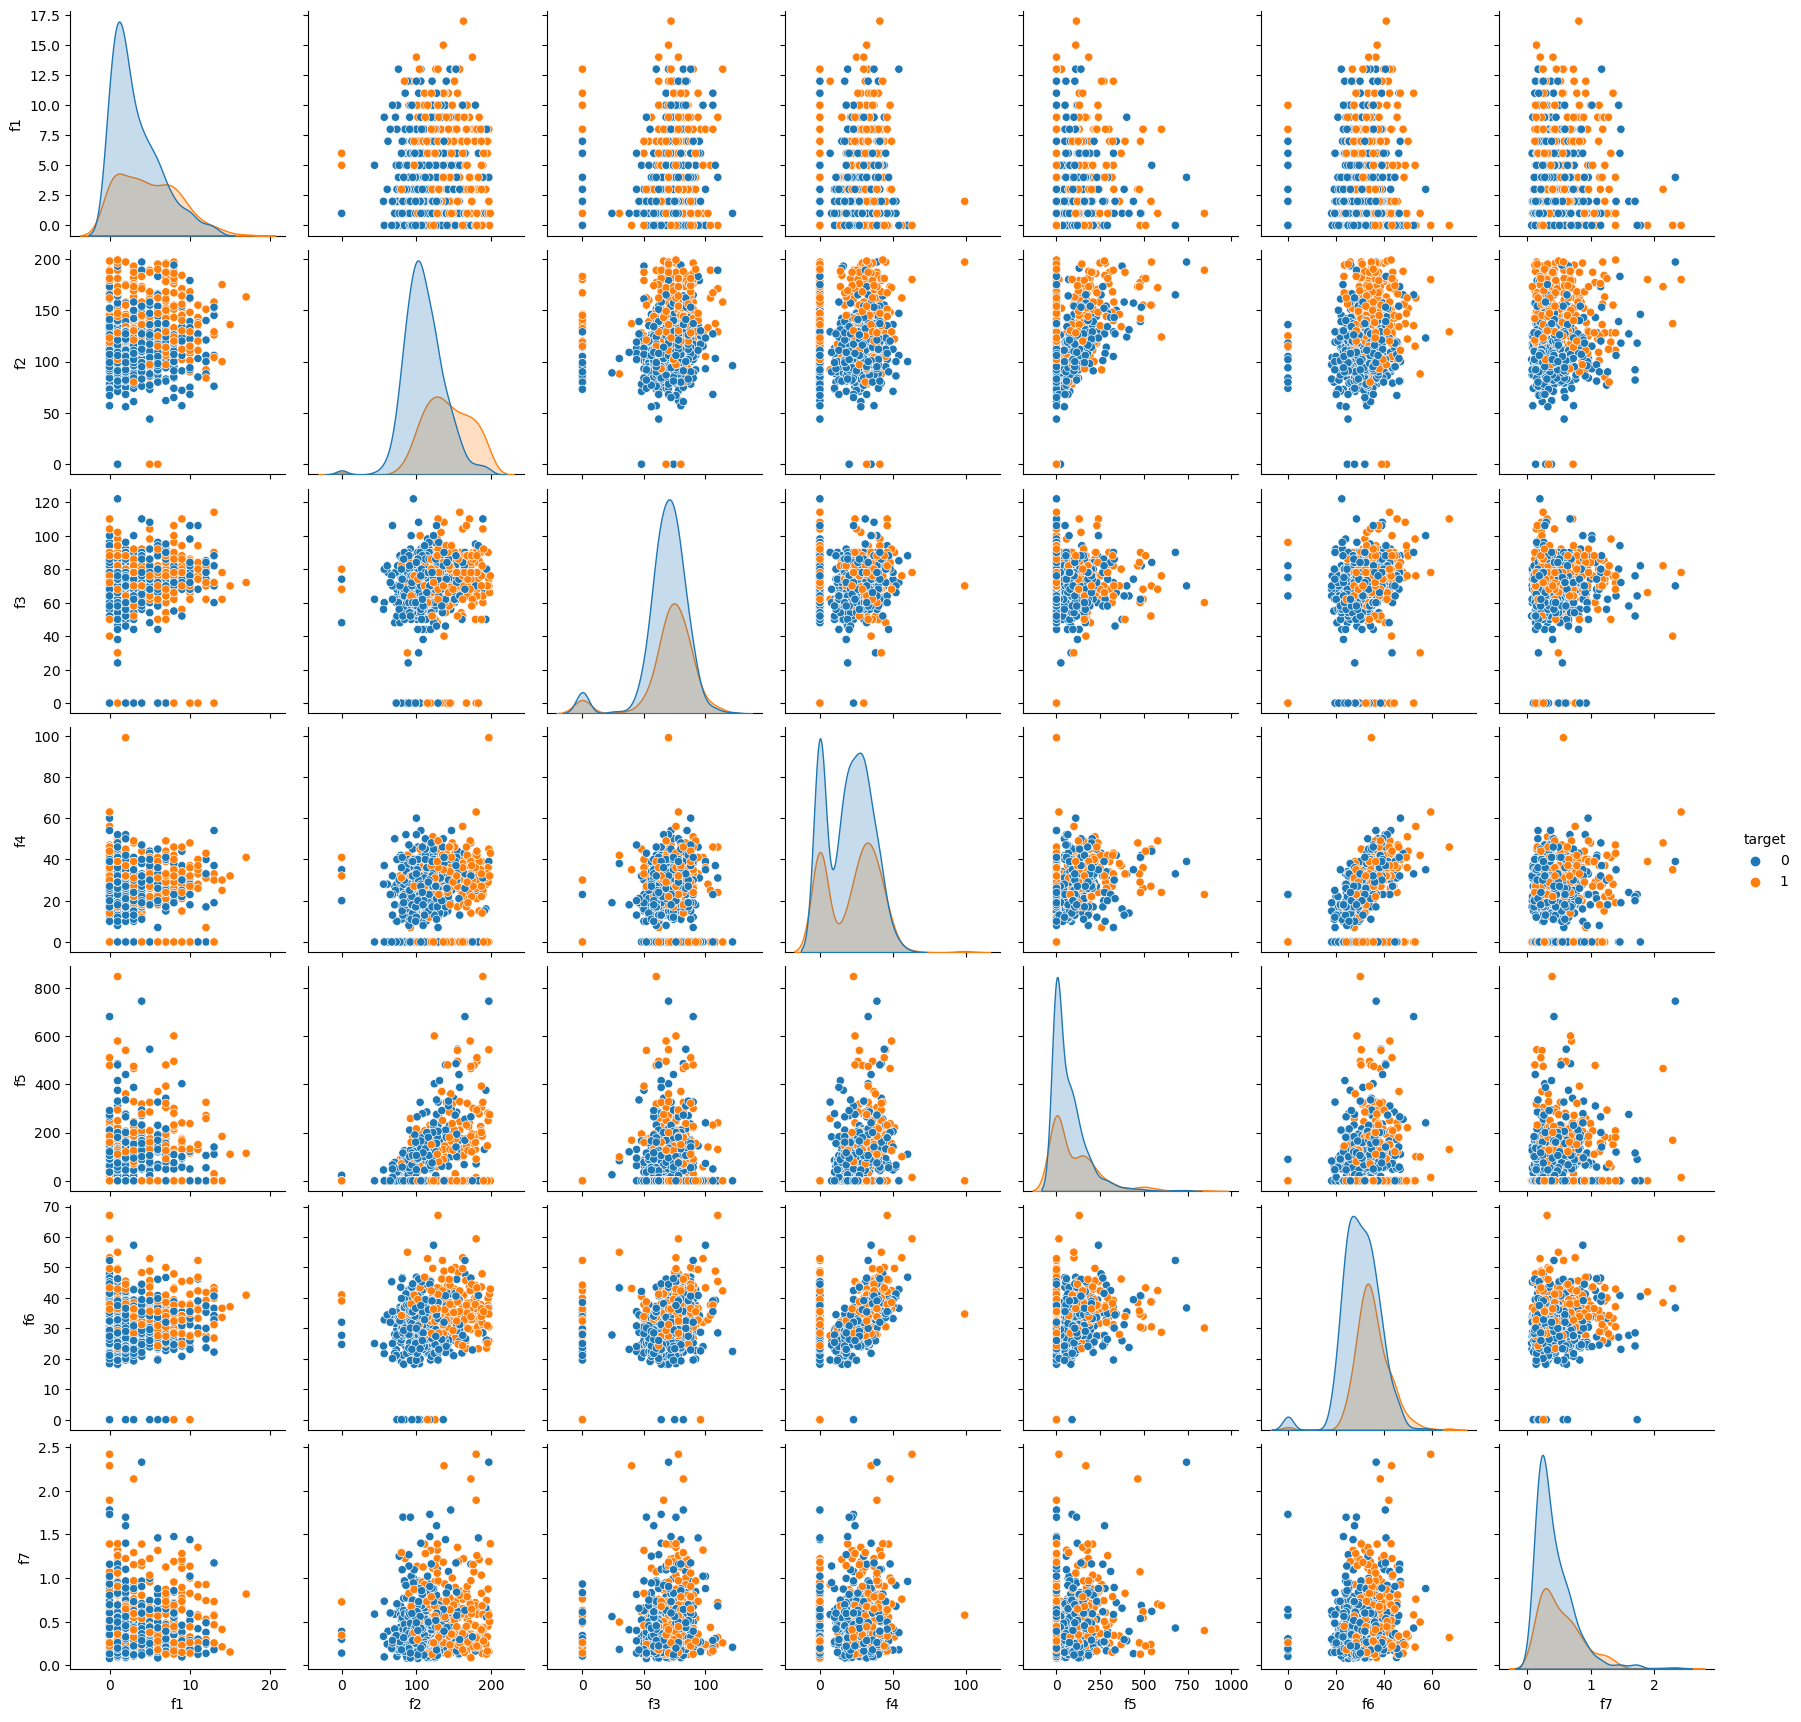

In [8]:
# pairplot
sns.pairplot(df,hue='target')

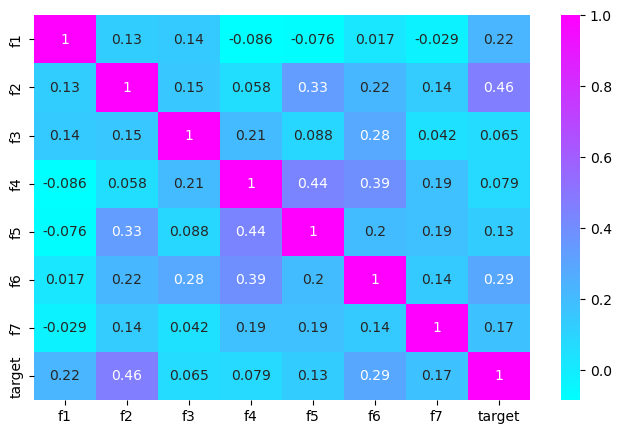

In [9]:
# heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(),annot=True,cmap='cool')
plt.show()

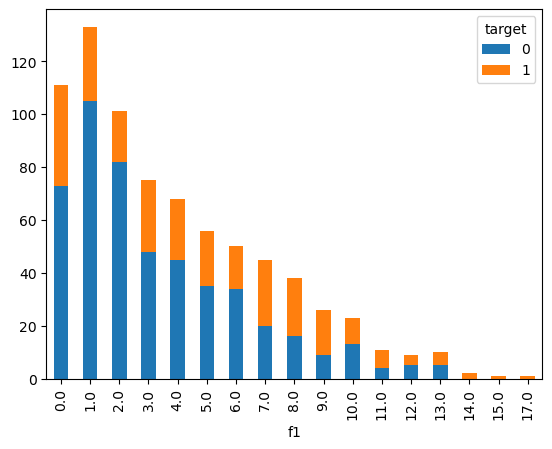

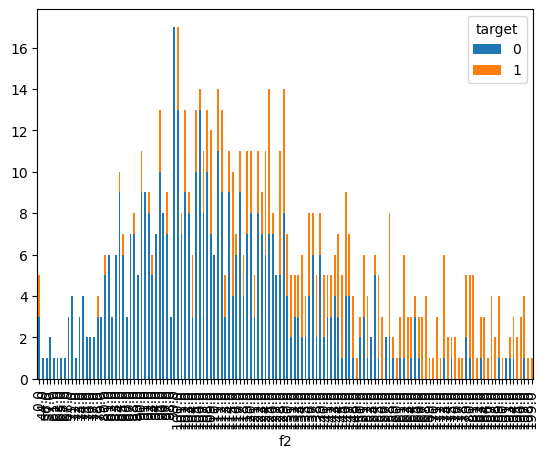

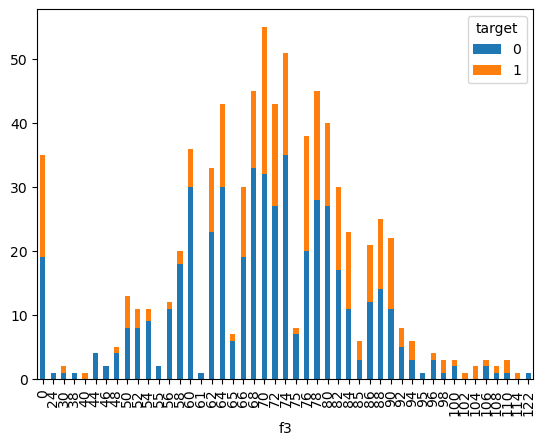

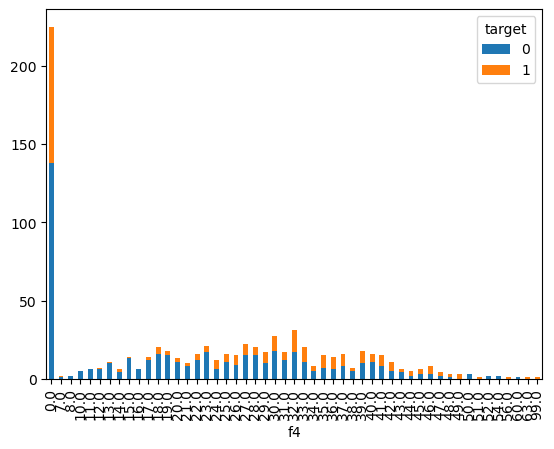

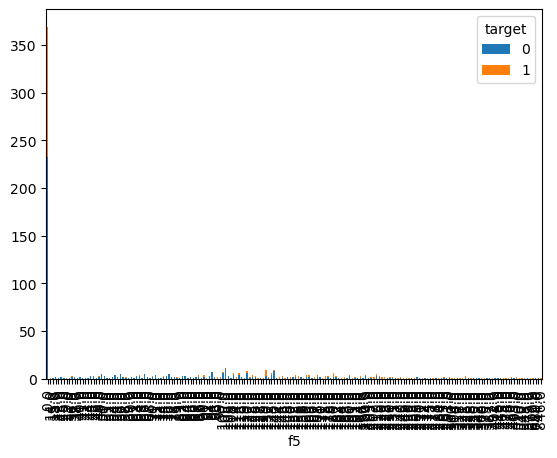

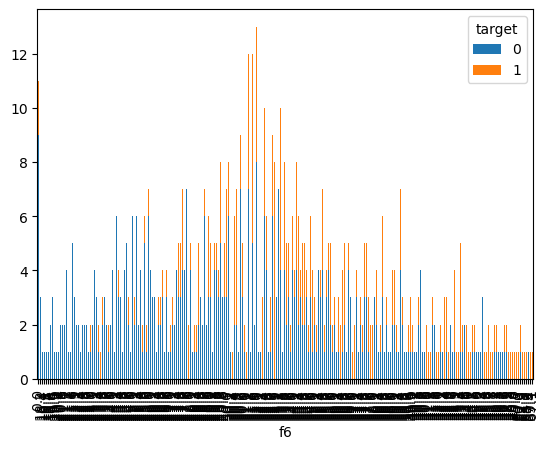

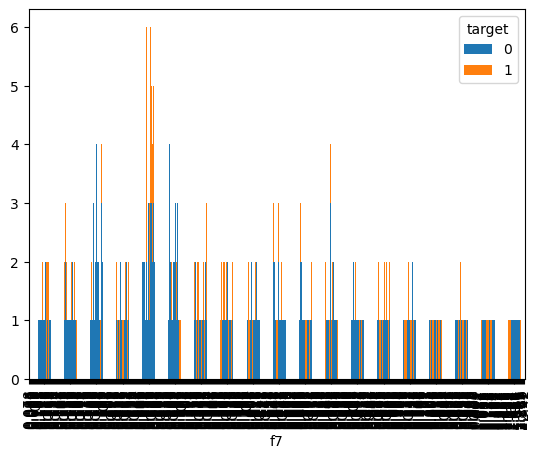

In [10]:
#stacked bar
pd.crosstab(df['f1'],df['target']).plot.bar(stacked=True)
pd.crosstab(df['f2'],df['target']).plot.bar(stacked=True)
pd.crosstab(df['f3'],df['target']).plot.bar(stacked=True)
pd.crosstab(df['f4'],df['target']).plot.bar(stacked=True)
pd.crosstab(df['f5'],df['target']).plot.bar(stacked=True)
pd.crosstab(df['f6'],df['target']).plot.bar(stacked=True)
pd.crosstab(df['f7'],df['target']).plot.bar(stacked=True)
plt.show()

In [11]:
df1=df.drop('target',axis=1)
df1

,f1,f2,f3,f4,f5,f6,f7
0,6.0,148.0,72,35.0,0.0,33.6,0.627
1,1.0,85.0,66,29.0,0.0,26.6,0.351
2,8.0,183.0,64,0.0,0.0,23.3,0.672
3,1.0,89.0,66,23.0,94.0,28.1,0.167
4,0.0,137.0,40,35.0,168.0,43.1,2.288
...,...,...,...,...,...,...,...
755,1.0,128.0,88,39.0,110.0,36.5,1.057
756,7.0,137.0,90,41.0,0.0,32.0,0.391
757,0.0,123.0,72,0.0,0.0,36.3,0.258
758,1.0,106.0,76,0.0,0.0,37.5,0.197


In [12]:
sc = StandardScaler()


In [13]:
df1_scaled=pd.DataFrame(sc.fit_transform(df1),columns=df1.columns)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
 X_train, X_test, y_train, y_test=train_test_split(df1_scaled,df['target'],test_size=0.20,random_state=42)

In [16]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [17]:
#Neural Network Architecture

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.hidden_layer1 = nn.Linear(7, 128)
        self.hidden_layer2 = nn.Linear(128, 128)
        self.hidden_layer3 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.relu(self.hidden_layer3(x))
        x = self.sigmoid(self.output_layer(x))
        return x

In [18]:
import torch.nn.functional as F
model=BinaryClassifier()
lr=0.0001
def train(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001, batch_size=32,optimizer = optim.Adam(model.parameters(), lr=lr)):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []
   
    
    
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        model.train()

        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_X)
            train_acc += ((output > 0.5).int() == batch_y.unsqueeze(1)).sum().item()

        model.eval()
        with torch.no_grad():
            output = model(X_test)
            valid_loss = criterion(output, y_test.unsqueeze(1).float()).item() * len(X_test)
            valid_acc = ((output > 0.5).int() == y_test.unsqueeze(1)).sum().item()
            
            
        train_loss /= len(X_train)
        valid_loss /= len(X_test)
        train_acc /= len(X_train)
        valid_acc /= len(X_test)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
     
        #print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {valid_acc:.4f}')

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list


In [19]:
model = BinaryClassifier()
train_loss_list, valid_loss_list,train_acc_list,valid_acc_list = train(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.0001, batch_size=32)

In [20]:
weights = model.state_dict()
torch.save(weights, 'nkumar27_jeevalka_assignment2_part1.pt')

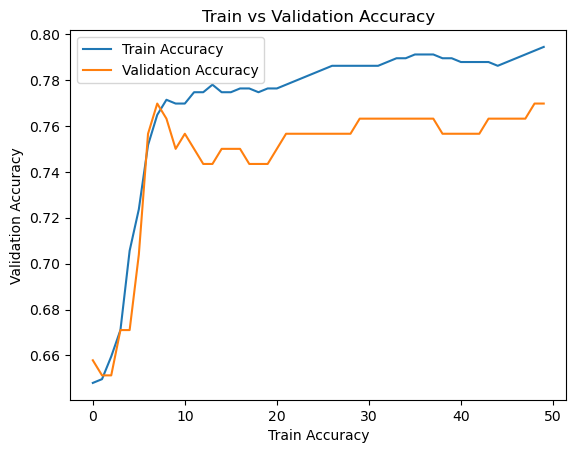

In [21]:
#Train vs Validation Loss Graph
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

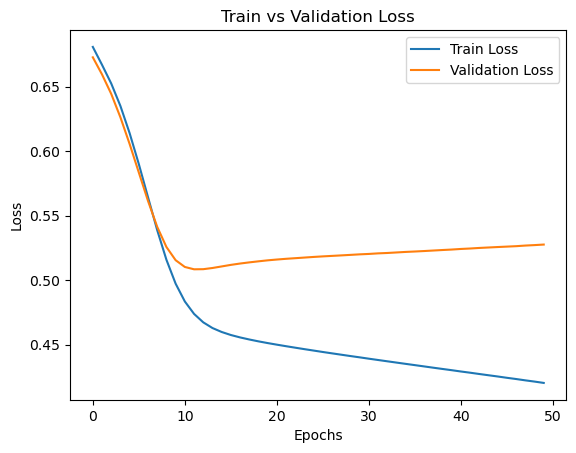

In [22]:
#Train vs Validation Loss Graph
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

In [23]:
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        pred = torch.round(output).squeeze()
        #print(pred)

    accuracy = torch.sum(pred == y_test).float() / len(y_test)
    print(f'Accuracy: {accuracy:.4f}')

    cm = confusion_matrix(y_test.numpy(), pred.numpy())
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.show()

Accuracy: 0.7697


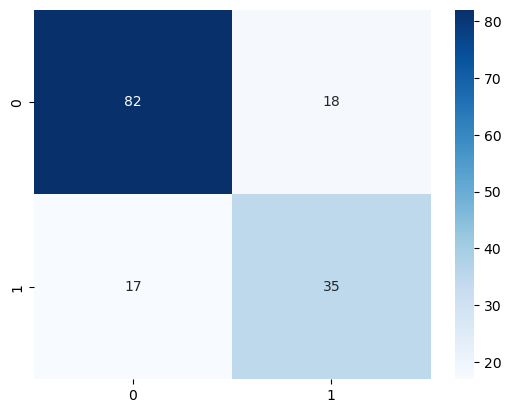

In [24]:
evaluate(model, X_test, y_test)

## SETUP - 1 
### Dropout Rate


In [25]:
class BinaryClassifierDropout(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BinaryClassifierDropout, self).__init__()
        self.hidden_layer1 = nn.Linear(7, 128)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.hidden_layer2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.hidden_layer3 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.dropout1(x)
        x = self.relu(self.hidden_layer2(x))
        x = self.dropout2(x)
        x = self.relu(self.hidden_layer3(x))
        x = self.dropout3(x)
        x = self.sigmoid(self.output_layer(x))
        return x


In [26]:
#Model with droput set at 0.1
model_dropout_0 = BinaryClassifierDropout(dropout_rate=0.1)
train_loss_list_dropout_0, valid_loss_list_dropout_0, train_acc_list_dropout_0, valid_acc_list_dropout_0 = train(model_dropout_0, X_train, y_train, X_test, y_test, epochs=50, lr=0.0001, batch_size=32)

#Model with droput set at 0.2
model_dropout_0_2 = BinaryClassifierDropout(dropout_rate=0.2)
train_loss_list_dropout_0_2, valid_loss_list_dropout_0_2, train_acc_list_dropout_0_2, valid_acc_list_dropout_0_2 = train(model_dropout_0_2, X_train, y_train, X_test, y_test, epochs=50, lr=0.0001, batch_size=32)


#Model with droput set at 0.5
model_dropout_0_5 = BinaryClassifierDropout(dropout_rate=0.5)
train_loss_list_dropout_0_5, valid_loss_list_dropout_0_5, train_acc_list_dropout_0_5, valid_acc_list_dropout_0_5 = train(model_dropout_0_5, X_train, y_train, X_test, y_test, epochs=50, lr=0.0001, batch_size=32)

Accuracy: 0.7500


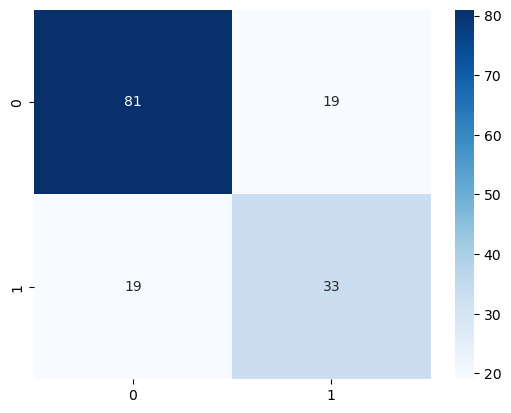

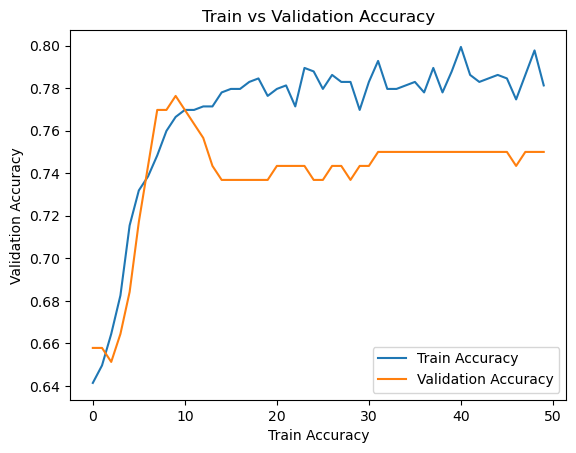

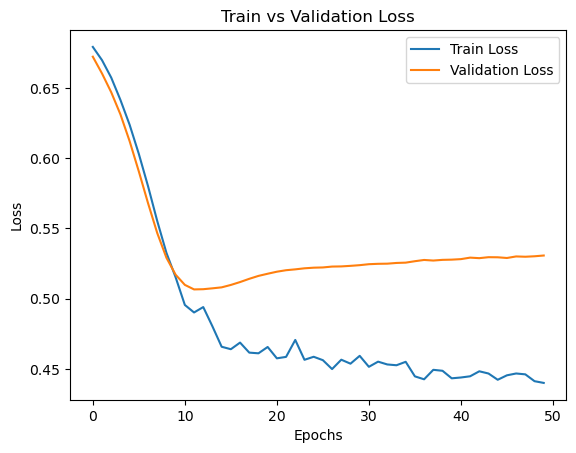

In [27]:
#Model with droput set at 0.1

evaluate(model_dropout_0, X_test, y_test)
plt.plot(train_acc_list_dropout_0)
plt.plot(valid_acc_list_dropout_0)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_dropout_0)
plt.plot(valid_loss_list_dropout_0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7500


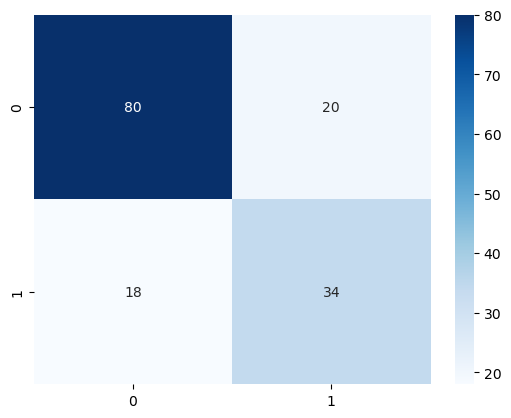

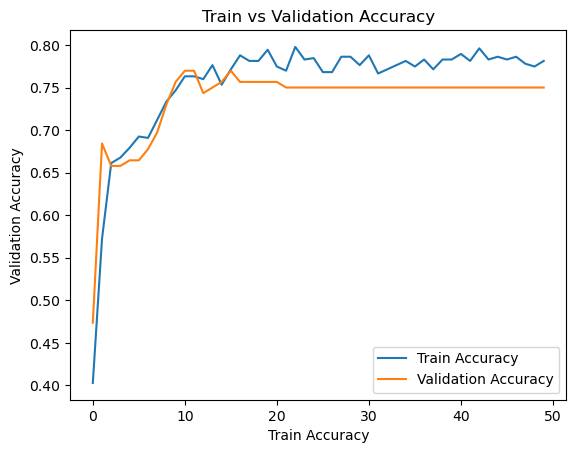

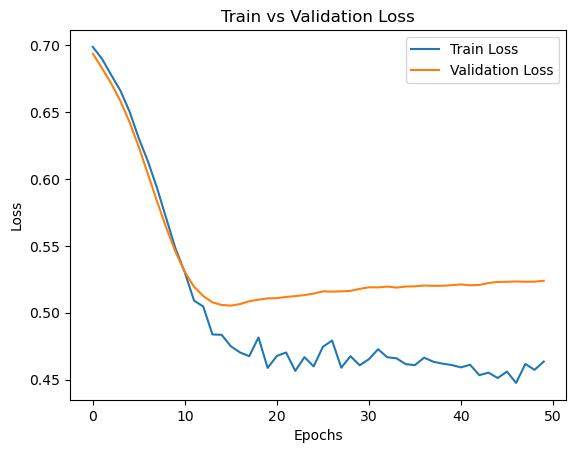

In [28]:
#Model with droput set at 0.2

evaluate(model_dropout_0_2, X_test, y_test)
plt.plot(train_acc_list_dropout_0_2)
plt.plot(valid_acc_list_dropout_0_2)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_dropout_0_2)
plt.plot(valid_loss_list_dropout_0_2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7763


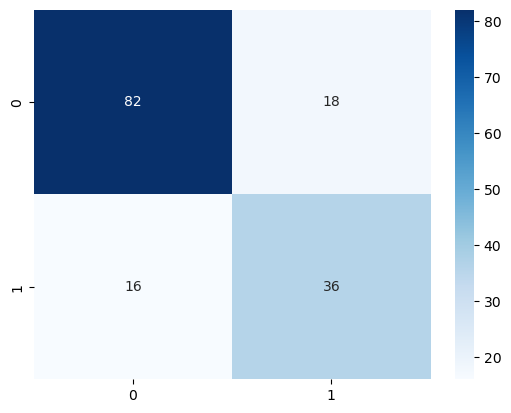

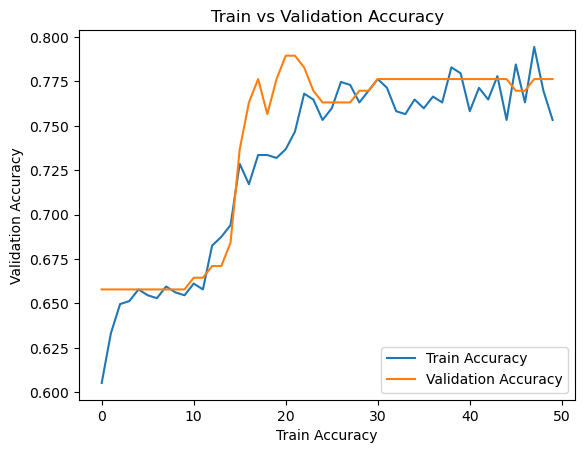

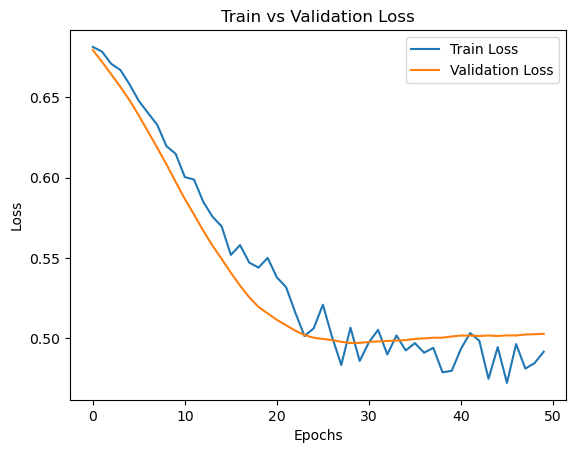

In [29]:
#Model with droput set at 0.5

evaluate(model_dropout_0_5, X_test, y_test)
plt.plot(train_acc_list_dropout_0_5)
plt.plot(valid_acc_list_dropout_0_5)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_dropout_0_5)
plt.plot(valid_loss_list_dropout_0_5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## SETUP - 2 
### Optimizer

In [30]:
# Define the BinaryClassifier model
model1 = BinaryClassifier()
model2 = BinaryClassifier()
model3 = BinaryClassifier()

#Using three different Optimizers
optimizers = [
    optim.Adam(model.parameters(), lr=0.0001),
    optim.SGD(model.parameters(), lr=0.0001),
    optim.RMSprop(model.parameters(), lr=0.0001),
]

train_loss_list_op1, valid_loss_list_op1, train_acc_list_op1, valid_acc_list_op1 = train(
        model=model1, 
        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        epochs=50, 
        lr=0.0001, 
        batch_size=32,
        optimizer=optimizers[0],
    )

train_loss_list_op2, valid_loss_list_op2, train_acc_list_op2, valid_acc_list_op2 = train(
        model=model2, 
        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        epochs=50, 
        lr=0.0001, 
        batch_size=32,
        optimizer=optimizers[1],
    )

train_loss_list_op3, valid_loss_list_op3, train_acc_list_op3, valid_acc_list_op3 = train(
        model=model3, 
        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        epochs=50, 
        lr=0.0001, 
        batch_size=32,
        optimizer=optimizers[2],
    )

Accuracy: 0.7500


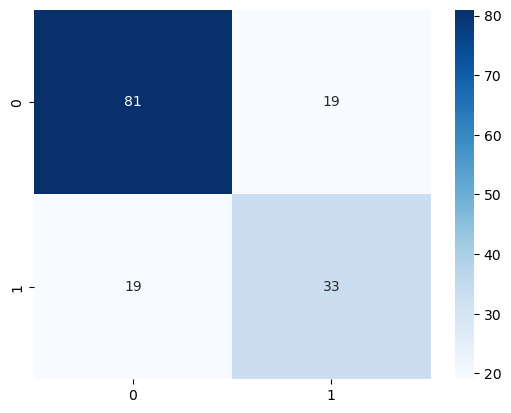

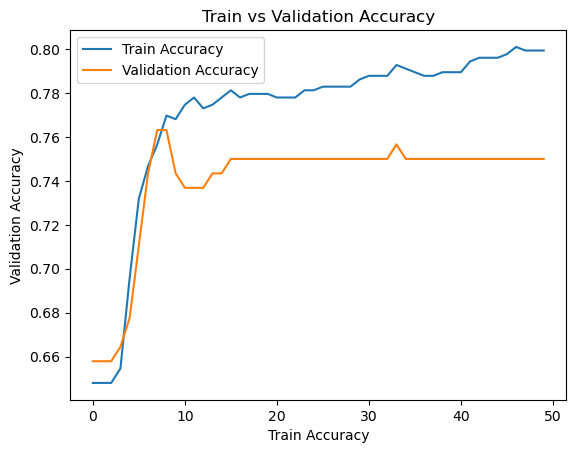

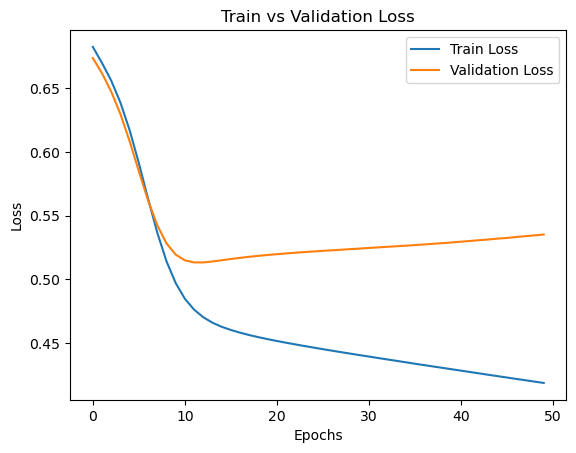

In [31]:
#Model with Adam Optimizer

evaluate(model1, X_test, y_test)
plt.plot(train_acc_list_op1)
plt.plot(valid_acc_list_op1)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_op1)
plt.plot(valid_loss_list_op1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7632


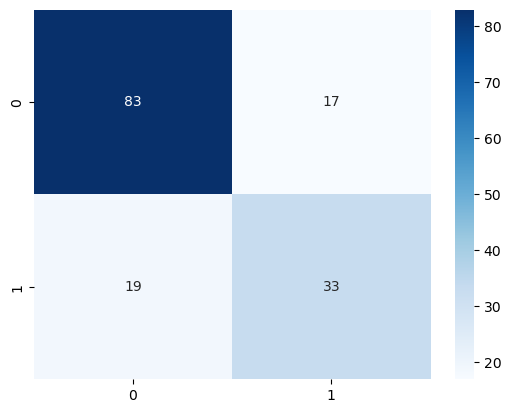

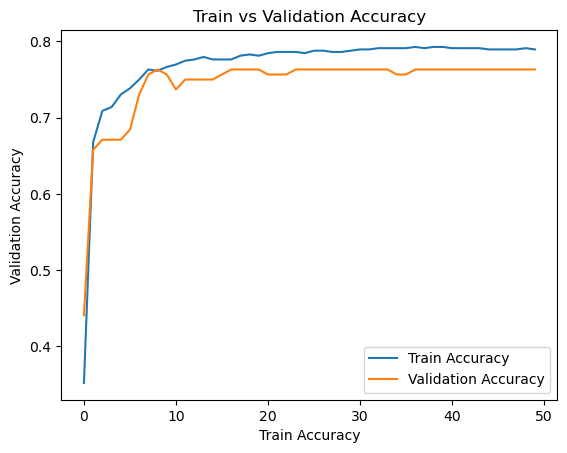

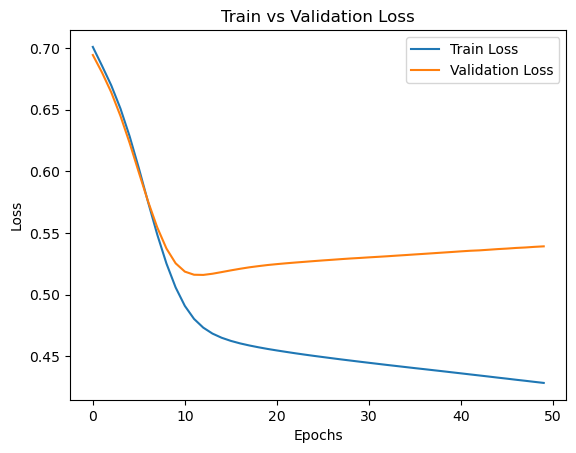

In [32]:
#Model with SGD Optimizer

evaluate(model2, X_test, y_test)
plt.plot(train_acc_list_op2)
plt.plot(valid_acc_list_op2)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_op2)
plt.plot(valid_loss_list_op2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7434


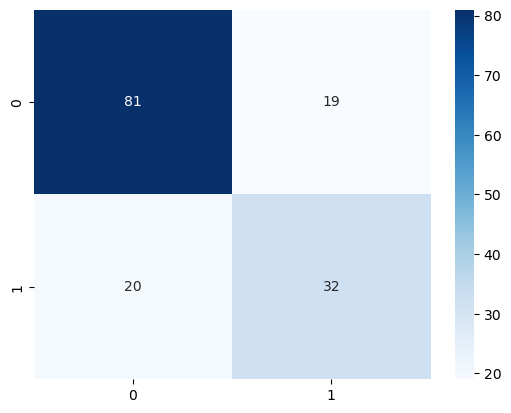

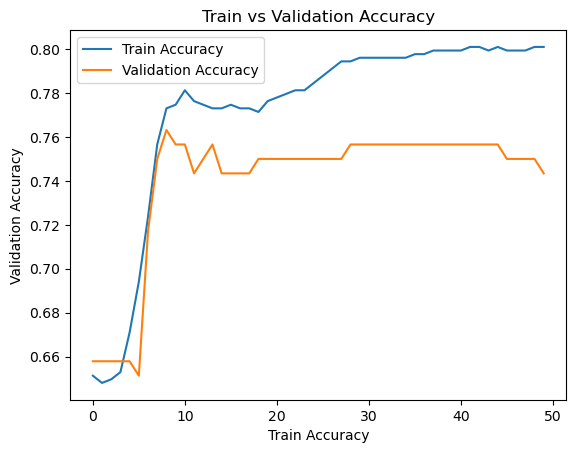

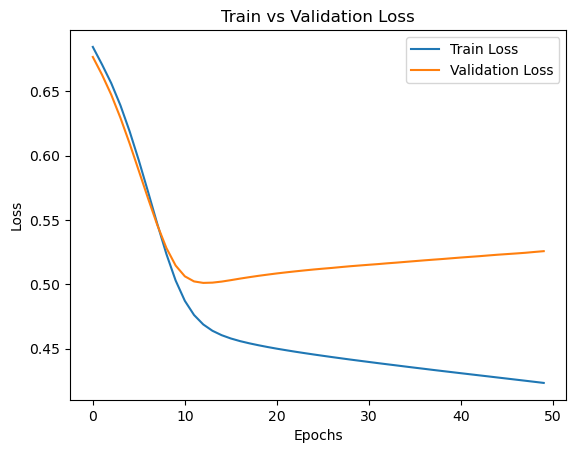

In [33]:
#Model with RMSprop Optimizer

evaluate(model3, X_test, y_test)
plt.plot(train_acc_list_op3)
plt.plot(valid_acc_list_op3)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_op3)
plt.plot(valid_loss_list_op3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## SETUP - 3 
### Intitializer

In [34]:
import torch.nn.init as init

# Define the initializers
initializers = [init.xavier_uniform_, init.kaiming_uniform_, init.orthogonal_]

# Train the model with each initializer

model11 = BinaryClassifier()
init.xavier_uniform_(model11.hidden_layer1.weight)
init.xavier_uniform_(model11.hidden_layer2.weight)
init.xavier_uniform_(model11.hidden_layer3.weight)
init.xavier_uniform_(model11.output_layer.weight)

   
train_loss_list_i1, valid_loss_list_i1, train_acc_list_i1, valid_acc_list_i1 = train(model11, X_train, y_train, X_test, y_test,epochs=50, 
        lr=0.0001, 
        batch_size=32)

model22 = BinaryClassifier()
init.kaiming_uniform_(model22.hidden_layer1.weight)
init.kaiming_uniform_(model22.hidden_layer2.weight)
init.kaiming_uniform_(model22.hidden_layer3.weight)
init.kaiming_uniform_(model22.output_layer.weight)

   
train_loss_list_i2, valid_loss_list_i2, train_acc_list_i2, valid_acc_list_i2 = train(model22, X_train, y_train, X_test, y_test,epochs=50, 
        lr=0.0001, 
        batch_size=32)


model33 = BinaryClassifier()
init.orthogonal_(model33.hidden_layer1.weight)
init.orthogonal_(model33.hidden_layer2.weight)
init.orthogonal_(model33.hidden_layer3.weight)
init.orthogonal_(model33.output_layer.weight)

   
train_loss_list_i3, valid_loss_list_i3, train_acc_list_i3, valid_acc_list_i3 = train(model33, X_train, y_train, X_test, y_test,epochs=50, 
        lr=0.0001, 
        batch_size=32)



Accuracy: 0.7632


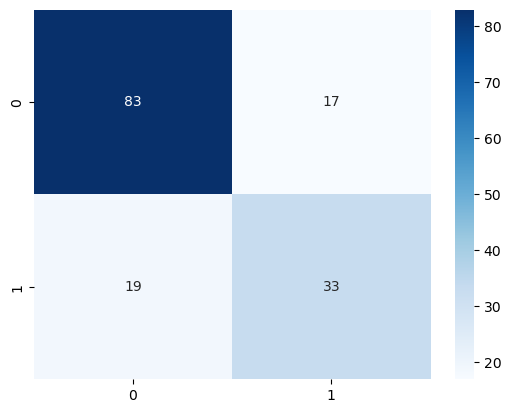

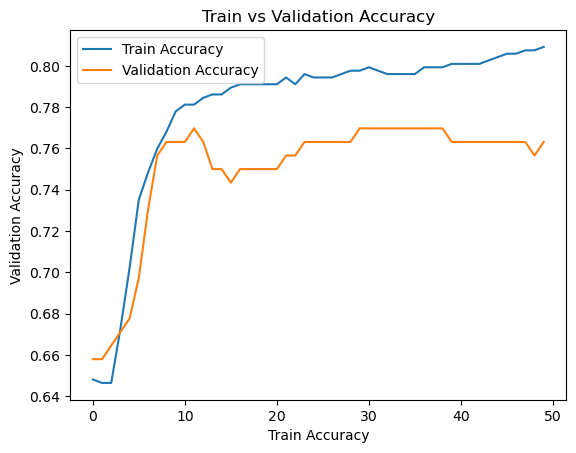

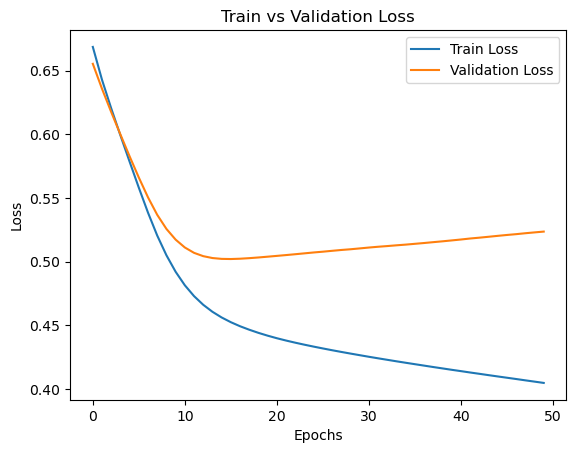

In [35]:
#Model with xavier_uniform_

evaluate(model11, X_test, y_test)
plt.plot(train_acc_list_i1)
plt.plot(valid_acc_list_i1)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_i1)
plt.plot(valid_loss_list_i1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7171


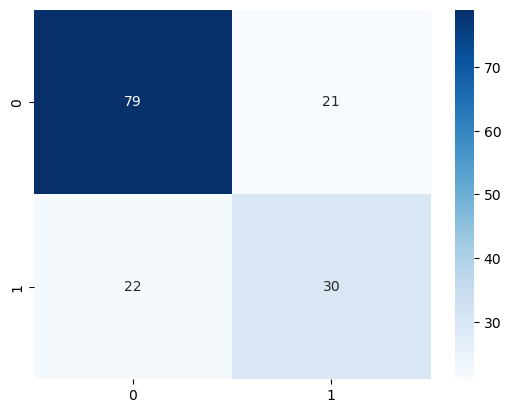

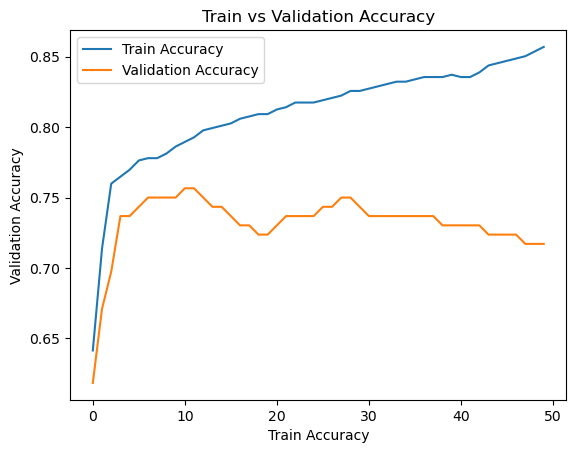

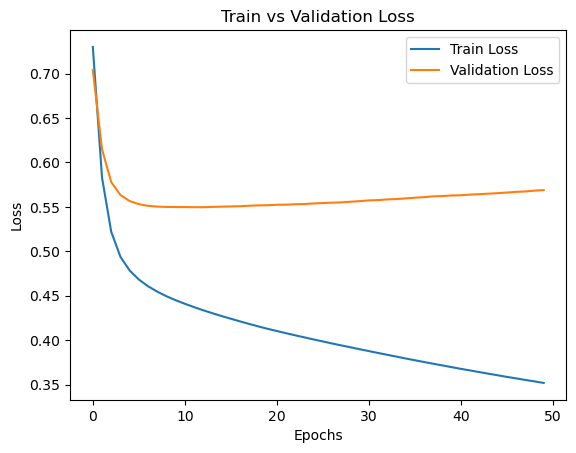

In [36]:
#Model with init.kaiming_uniform_

evaluate(model22, X_test, y_test)
plt.plot(train_acc_list_i2)
plt.plot(valid_acc_list_i2)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_i2)
plt.plot(valid_loss_list_i2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7566


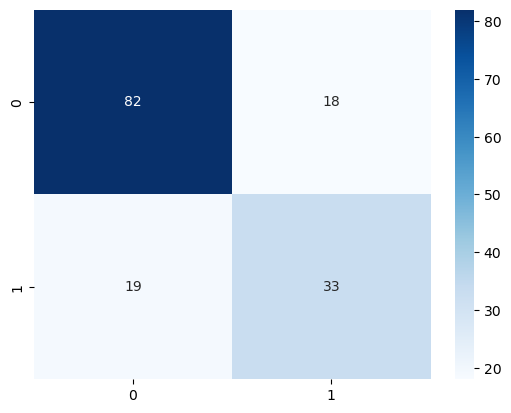

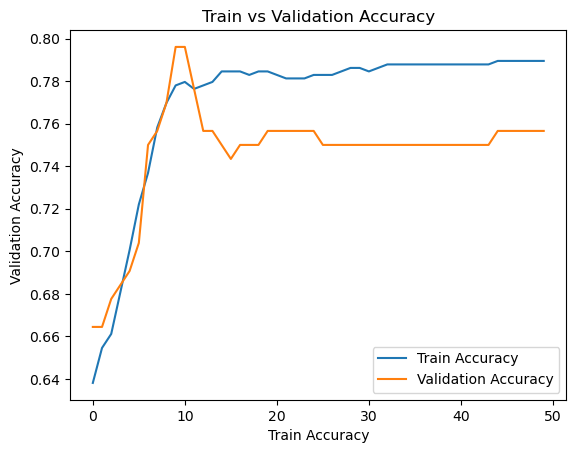

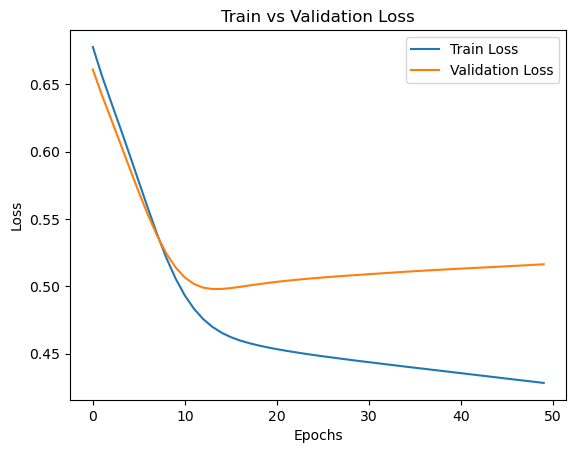

In [37]:
#Model with init.orthogonal_

evaluate(model33, X_test, y_test)
plt.plot(train_acc_list_i3)
plt.plot(valid_acc_list_i3)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_i3)
plt.plot(valid_loss_list_i3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

## SETUP - 4 
### Activation Function


In [38]:
# Define the neural network architecture
class BinaryClassifierActivation(nn.Module):
    def __init__(self, activation):
        super(BinaryClassifierActivation, self).__init__()
        self.hidden_layer1 = nn.Linear(7, 128)
        self.hidden_layer2 = nn.Linear(128, 128)
        self.hidden_layer3 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)
        self.activation = activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.hidden_layer1(x))
        x = self.activation(self.hidden_layer2(x))
        x = self.activation(self.hidden_layer3(x))
        x = self.sigmoid(self.output_layer(x))
        return x

    
# Train the model with ReLU activation function
model_relu = BinaryClassifierActivation(nn.ReLU())
train_loss_list_a1, valid_loss_list_a1, train_acc_list_a1, valid_acc_list_a1 = train(model_relu, X_train, y_train, X_test, y_test, epochs=50, 
        lr=0.0001, 
        batch_size=32)

# Train the model with Tanh activation function
model_tanh = BinaryClassifierActivation(nn.Tanh())
train_loss_list_a2, valid_loss_list_a2, train_acc_list_a2, valid_acc_list_a2 = train(model_tanh, X_train, y_train, X_test, y_test, epochs=50, 
        lr=0.0001, 
        batch_size=32)

# Train the model with Sigmoid activation
model_sigmoid = BinaryClassifierActivation(nn.Sigmoid())
train_loss_list_a3, valid_loss_list_a3, train_acc_list_a3, valid_acc_list_a3 = train(model_sigmoid, X_train, y_train, X_test, y_test, epochs=100, 
        lr=0.0001, 
        batch_size=32)

Accuracy: 0.7500


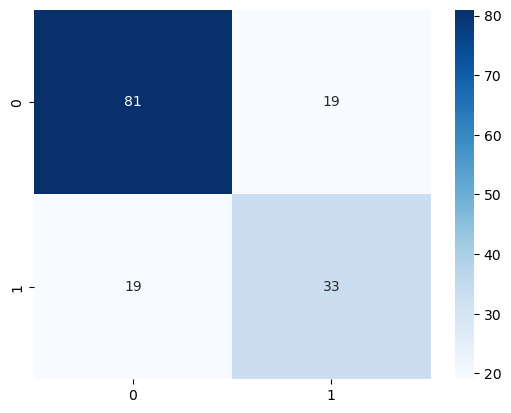

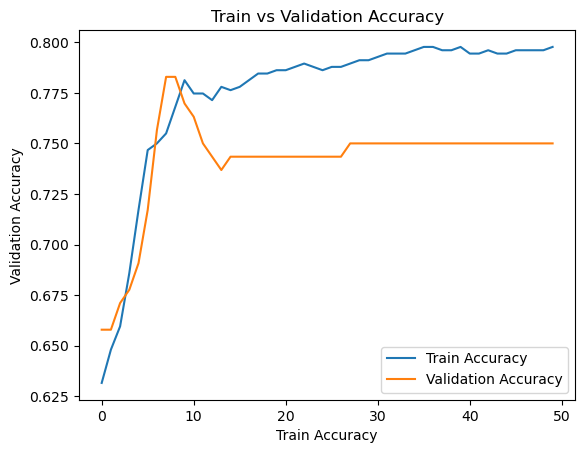

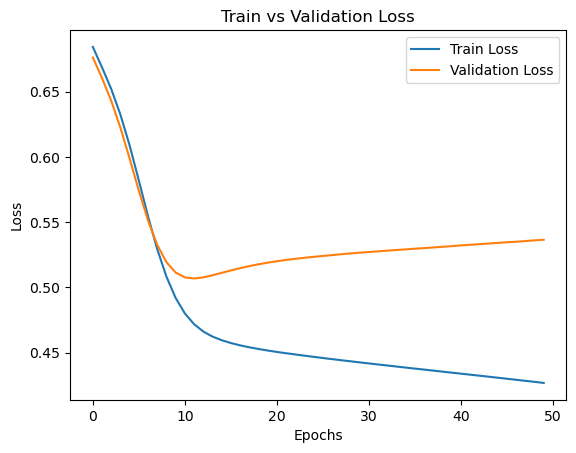

In [39]:
#Model with Activation function as ReLu

evaluate(model_relu, X_test, y_test)
plt.plot(train_acc_list_a1)
plt.plot(valid_acc_list_a1)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_a1)
plt.plot(valid_loss_list_a1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7368


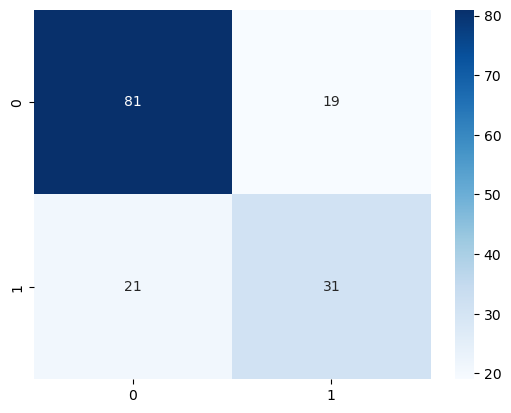

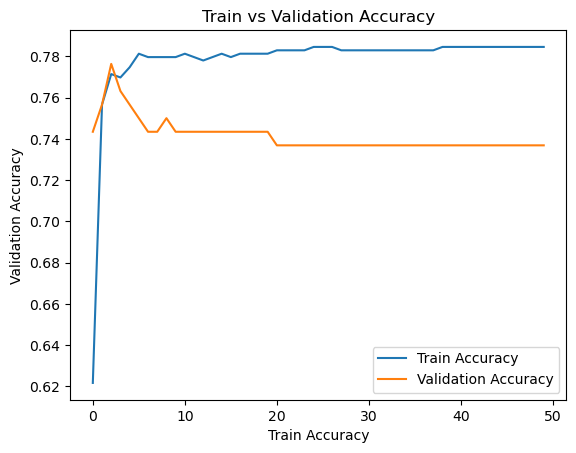

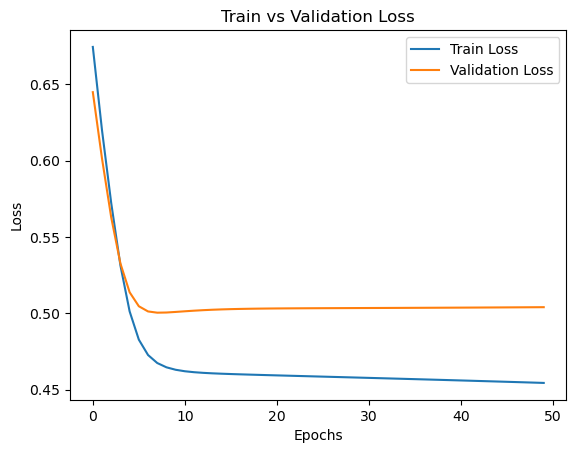

In [40]:
#Model with Activation function as tanh

evaluate(model_tanh, X_test, y_test)
plt.plot(train_acc_list_a2)
plt.plot(valid_acc_list_a2)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_a2)
plt.plot(valid_loss_list_a2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Accuracy: 0.7697


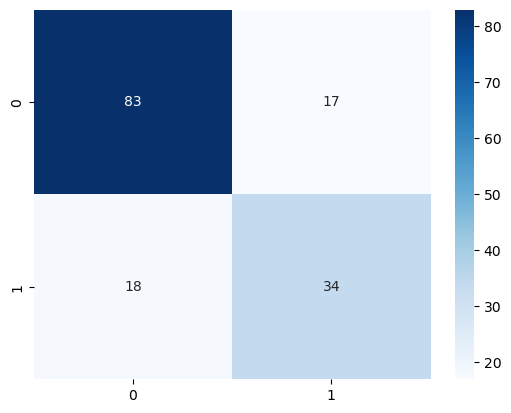

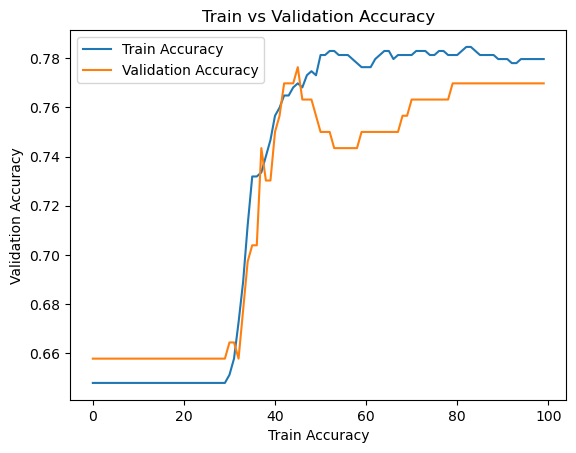

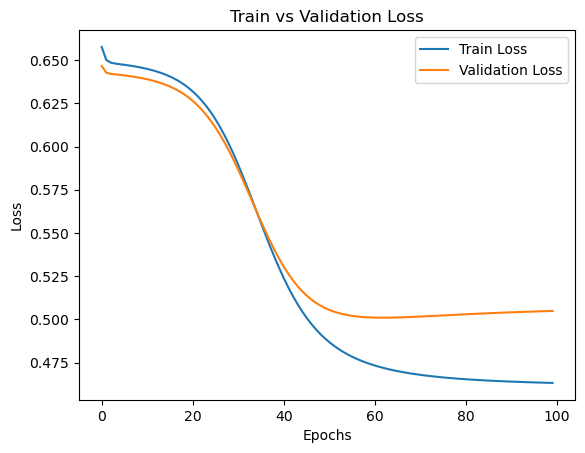

In [41]:
#Model with Activation function as sigmoid

evaluate(model_sigmoid, X_test, y_test)
plt.plot(train_acc_list_a3)
plt.plot(valid_acc_list_a3)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_a3)
plt.plot(valid_loss_list_a3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

# Base Model

We select the model with the relu activation function as the base model as it promises to give us the highest accuracy. 

In [42]:
model = BinaryClassifier()

# Trying Different Methods

### Early Stopping

In [43]:
# let us add the early stopping feature to the train function.

import torch.nn.functional as F
lr=0.0001
def train_es(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001, batch_size=32,optimizer = optim.Adam(model.parameters(), lr=lr)):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []
    early_stopping = EarlyStopping(patience=20, verbose=True)
    
    
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        model.train()

        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_X)
            train_acc += ((output > 0.5).int() == batch_y.unsqueeze(1)).sum().item()

        model.eval()
        with torch.no_grad():
            output = model(X_test)
            valid_loss = criterion(output, y_test.unsqueeze(1).float()).item() * len(X_test)
            valid_acc = ((output > 0.5).int() == y_test.unsqueeze(1)).sum().item()
            
            
        train_loss /= len(X_train)
        valid_loss /= len(X_test)
        train_acc /= len(X_train)
        valid_acc /= len(X_test)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping.")
            break
     
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {valid_acc:.4f}')

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list


In [44]:
train_loss_list_es, valid_loss_list_es, train_acc_list_es, valid_acc_list_es = train_es(model, X_train, y_train, X_test, y_test, epochs=50, 
        lr=0.0001, 
        batch_size=8)

Validation loss decreased (inf --> 0.632121).  Saving model ...
Epoch: 1/50, Train Loss: 0.6560, Valid Loss: 0.6321, Train Accuracy: 0.6480, Test Accuracy: 0.6579
Validation loss decreased (0.632121 --> 0.577915).  Saving model ...
Epoch: 2/50, Train Loss: 0.6001, Valid Loss: 0.5779, Train Accuracy: 0.6957, Test Accuracy: 0.7039
Validation loss decreased (0.577915 --> 0.531493).  Saving model ...
Epoch: 3/50, Train Loss: 0.5385, Valid Loss: 0.5315, Train Accuracy: 0.7549, Test Accuracy: 0.7632
Validation loss decreased (0.531493 --> 0.513134).  Saving model ...
Epoch: 4/50, Train Loss: 0.4949, Valid Loss: 0.5131, Train Accuracy: 0.7714, Test Accuracy: 0.7434
Validation loss decreased (0.513134 --> 0.511753).  Saving model ...
Epoch: 5/50, Train Loss: 0.4748, Valid Loss: 0.5118, Train Accuracy: 0.7697, Test Accuracy: 0.7434
EarlyStopping counter: 1 out of 20
Epoch: 6/50, Train Loss: 0.4664, Valid Loss: 0.5143, Train Accuracy: 0.7747, Test Accuracy: 0.7368
EarlyStopping counter: 2 out of

Accuracy: 0.7500


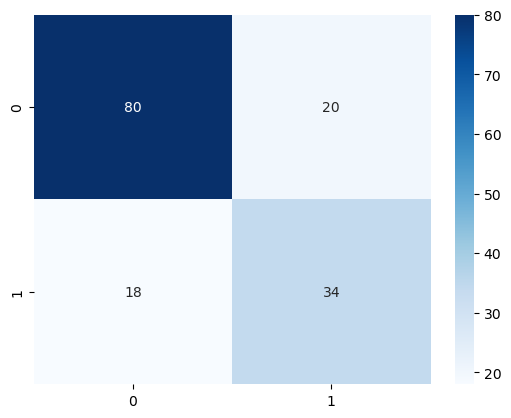

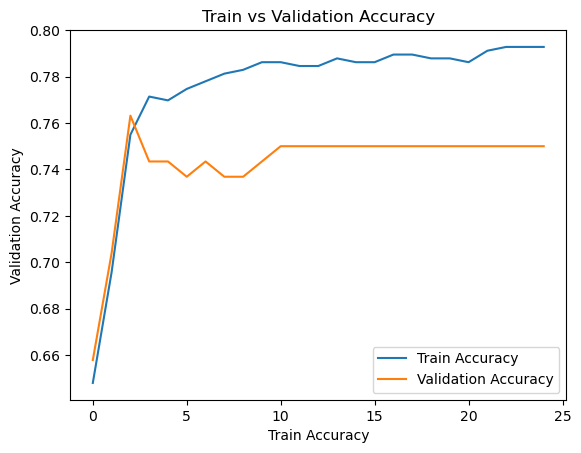

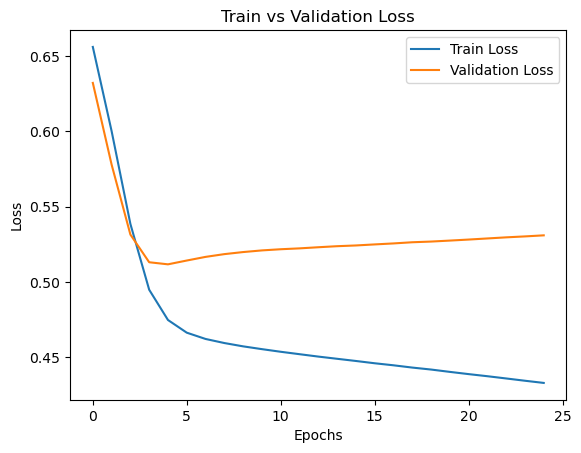

In [45]:
evaluate(model, X_test, y_test)
plt.plot(train_acc_list_es)
plt.plot(valid_acc_list_es)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_es)
plt.plot(valid_loss_list_es)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

### Learning Rate Scheduler

In [46]:
# Let us add Learning Rate Scheduler to the train function. 
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
model=BinaryClassifier()
lr=0.0001
def train_lrs(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001, batch_size=32,optimizer = optim.Adam(model.parameters(), lr=lr)):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.BCELoss()
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []
   
    
    
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        model.train()

        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_X)
            train_acc += ((output > 0.5).int() == batch_y.unsqueeze(1)).sum().item()

        model.eval()
        with torch.no_grad():
            output = model(X_test)
            valid_loss = criterion(output, y_test.unsqueeze(1).float()).item() * len(X_test)
            valid_acc = ((output > 0.5).int() == y_test.unsqueeze(1)).sum().item()
            
        scheduler.step()   
        train_loss /= len(X_train)
        valid_loss /= len(X_test)
        train_acc /= len(X_train)
        valid_acc /= len(X_test)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
     
        #print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {valid_acc:.4f}')

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list


In [47]:
train_loss_list_lrs, valid_loss_list_lrs, train_acc_list_lrs, valid_acc_list_lrs = train_lrs(model, X_train, y_train, X_test, y_test, epochs=50, 
        lr=0.0001, 
        batch_size=8)

In [48]:
weights = model.state_dict()
torch.save(weights, 'nkumar27_jeevalka_assignment2_part2.pt')

Accuracy: 0.7697


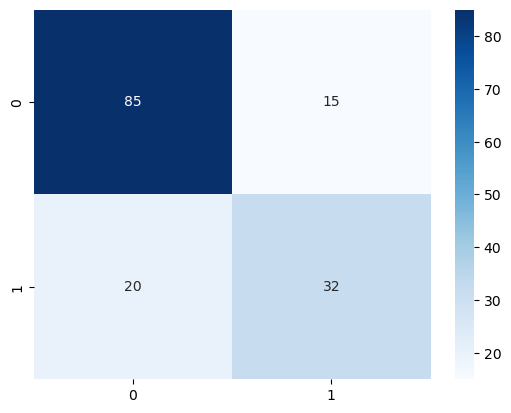

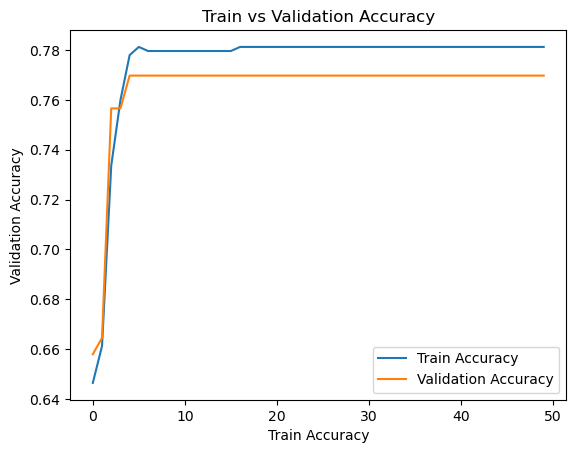

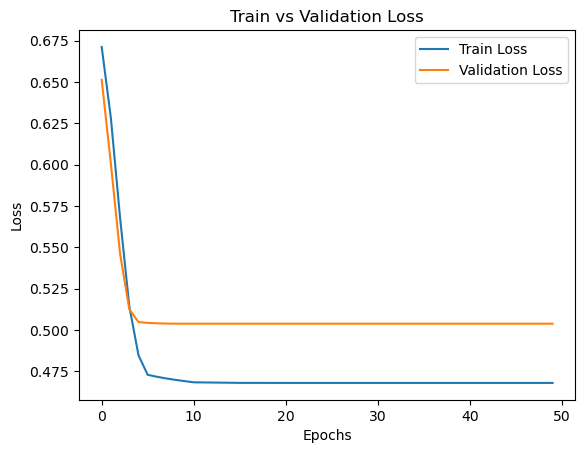

In [49]:
evaluate(model, X_test, y_test)
plt.plot(train_acc_list_lrs)
plt.plot(valid_acc_list_lrs)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_lrs)
plt.plot(valid_loss_list_lrs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

### Gradient Clipping

In [50]:
# Let us add gradient clipping to the training function
import torch.nn.functional as F
model=BinaryClassifier()
lr=0.0001
max_grad_norm = 1.0 # Maximum gradient norm allowed
def train_gc(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001, batch_size=32,optimizer = optim.Adam(model.parameters(), lr=lr)):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []
   
    
    
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        model.train()

        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y.unsqueeze(1).float())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            train_loss += loss.item() * len(batch_X)
            train_acc += ((output > 0.5).int() == batch_y.unsqueeze(1)).sum().item()

        model.eval()
        with torch.no_grad():
            output = model(X_test)
            valid_loss = criterion(output, y_test.unsqueeze(1).float()).item() * len(X_test)
            valid_acc = ((output > 0.5).int() == y_test.unsqueeze(1)).sum().item()
            
            
        train_loss /= len(X_train)
        valid_loss /= len(X_test)
        train_acc /= len(X_train)
        valid_acc /= len(X_test)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
     
        #print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {valid_acc:.4f}')

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list


In [51]:
train_loss_list_gc, valid_loss_list_gc, train_acc_list_gc, valid_acc_list_gc = train_gc(model, X_train, y_train, X_test, y_test, epochs=30, 
        lr=0.0001, 
        batch_size=8)

Accuracy: 0.7500


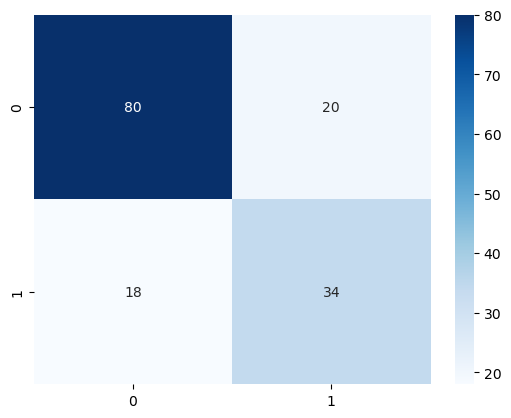

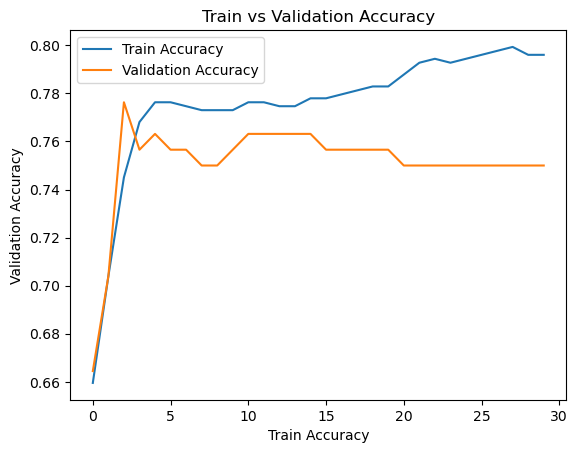

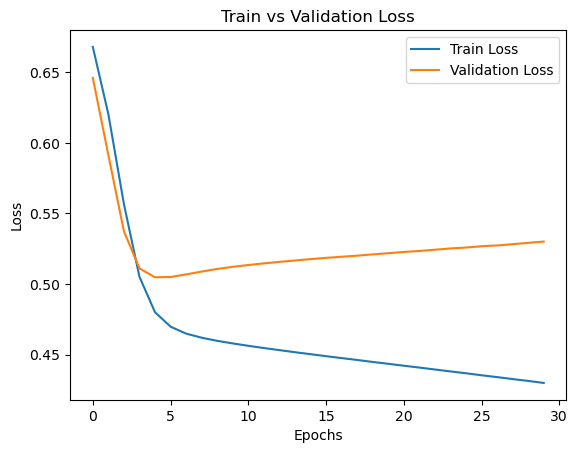

In [52]:
evaluate(model, X_test, y_test)
plt.plot(train_acc_list_gc)
plt.plot(valid_acc_list_gc)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_gc)
plt.plot(valid_loss_list_gc)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

### Batch Normalization

In [53]:
#Neural Network Architecture

class BinaryClassifierBN(nn.Module):
    def __init__(self):
        super(BinaryClassifierBN, self).__init__()
        self.hidden_layer1 = nn.Linear(7, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden_layer2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.hidden_layer3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output_layer = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.hidden_layer1(x)))
        x = self.relu(self.bn2(self.hidden_layer2(x)))
        x = self.relu(self.bn3(self.hidden_layer3(x)))
        x = self.sigmoid(self.output_layer(x))
        return x

In [54]:
model = BinaryClassifierBN()


In [55]:
train_loss_list_bn, valid_loss_list_bn, train_acc_list_bn, valid_acc_list_bn = train(model, X_train, y_train, X_test, y_test, epochs=30, 
        lr=0.0001, 
        batch_size=8)

Accuracy: 0.7171


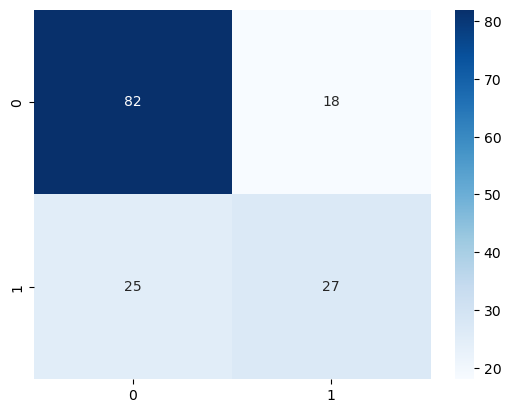

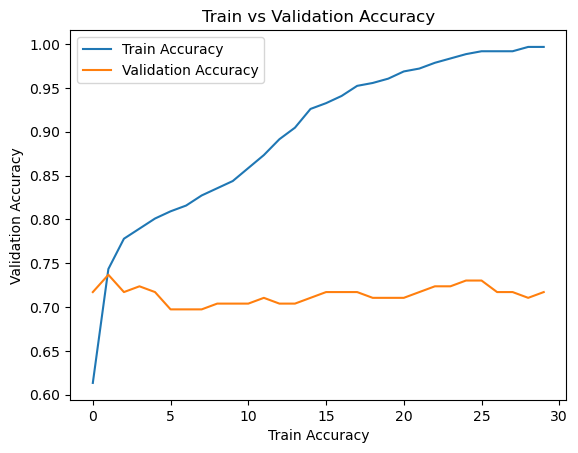

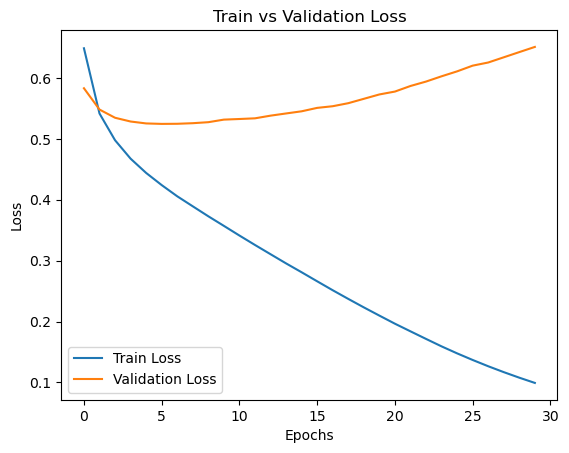

In [56]:
evaluate(model, X_test, y_test)
plt.plot(train_acc_list_bn)
plt.plot(valid_acc_list_bn)
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

#Train vs Validation Loss Graph
plt.plot(train_loss_list_bn)
plt.plot(valid_loss_list_bn)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

Reference: 
For Early Stopping Class:
https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py